In [2]:
import mat73
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import random
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
np.random.seed(0)

In [3]:
def load_dataframe():
    data_dict = mat73.loadmat('spect_phee2monkey_mel_cell_nopadding_streched_50x50.mat')
    data_dict["spect"] = [data_dict["spect"][:, :, i] for i in range(data_dict["spect"].shape[2])]
    df = pd.DataFrame(data_dict)
    for name in ['callee', 'caller', 'expname']:
        df[name] = df[name].apply(lambda x: x[0])
    df.loc[df["callee"] == "Brhama", "callee"] = "Brahma"
    df.loc[df["caller"] == "Brhama", "caller"] = "Brahma"
    return df

In [4]:
def show_cm(cmn,title,labels):
    fig, ax = plt.subplots(figsize=(15,15))
    f = sns.heatmap(cmn, annot=True, fmt=".1%", linewidths=1.0, square=1, cmap='rocket_r')
    plt.title(title, fontsize=25)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)
    _ = ax.set_xticklabels(labels)
    _ = plt.xticks(rotation=70)
    _ = ax.set_yticklabels(labels)
    _ = plt.yticks(rotation=0)

In [5]:
def pred_percent_hist(conf_mats, labels):
    diagonals = []
    for i in range(len(labels)):
        diagonal = []
        for matrix in conf_mats:
            diagonal.append(np.diag(matrix)[i])
        diagonals.append(diagonal)

    plt.figure(figsize=(12,16))
    plt.suptitle("Predictions Percentage Histogram", size=25, y=1.01)
    for i, diagonal in enumerate(diagonals):
        plt.subplot(4, 2, i+1)
        plt.hist(diagonal)
        plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel(f'Percentage', size=15)
        plt.ylabel('Frequency', size=15)
        plt.title(f'Callee {labels[i]}', size=20)

    plt.tight_layout()
    plt.show()

In [6]:
df = load_dataframe()

In [7]:
df_flattened = df.copy(True)
flattened_features = pd.DataFrame(np.stack(np.asarray(df_flattened["spect"].apply(lambda x: x.flatten())), axis=0))
df_flattened = pd.concat([df_flattened.filter(items=["caller", "callee"]).reset_index(drop=True), flattened_features.reset_index(drop=True)], axis=1)

In [8]:
def pred_caller_to_callees_train_test(df, caller_label, callees_to_drop = [], repeat_amount = 100):
    df_caller = df[df["caller"] == caller_label].drop(columns="caller")
    df_caller = df_caller[~df_caller["callee"].isin(callees_to_drop)]
    X, y = df_caller.drop(columns="callee"),df_caller["callee"]
    labels = y.unique()
    cm_list = []
    oob_score_ls = []
    us = RandomUnderSampler()
    rfc = RandomForestClassifier(oob_score=True)
    for i in tqdm(range(repeat_amount)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        X_train_resampled, y_train_resampled = us.fit_resample(X_train,y_train)
        X_test_resampled, y_test_resampled = us.fit_resample(X_test,y_test)
        if i == 0:
            print("train:", y_train_resampled.value_counts())
            print("test:", y_test_resampled.value_counts())
        rfc.fit(X_train_resampled,y_train_resampled)
        y_pred = rfc.predict(X_test_resampled)
        cm = confusion_matrix(y_true=y_test_resampled, y_pred=y_pred, labels=np.unique(y_test_resampled))
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_list.append(cmn)
        oob_score_ls.append(rfc.oob_score_)
    return cm_list, np.mean(oob_score_ls), labels

  0%|          | 0/100 [00:00<?, ?it/s]

train: Adonis      540
Bhumi       540
Brahma      540
Ceto        540
Dionysus    540
Name: callee, dtype: int64
test: Adonis      174
Bhumi       174
Brahma      174
Ceto        174
Dionysus    174
Name: callee, dtype: int64


100%|██████████| 100/100 [46:17<00:00, 27.77s/it]


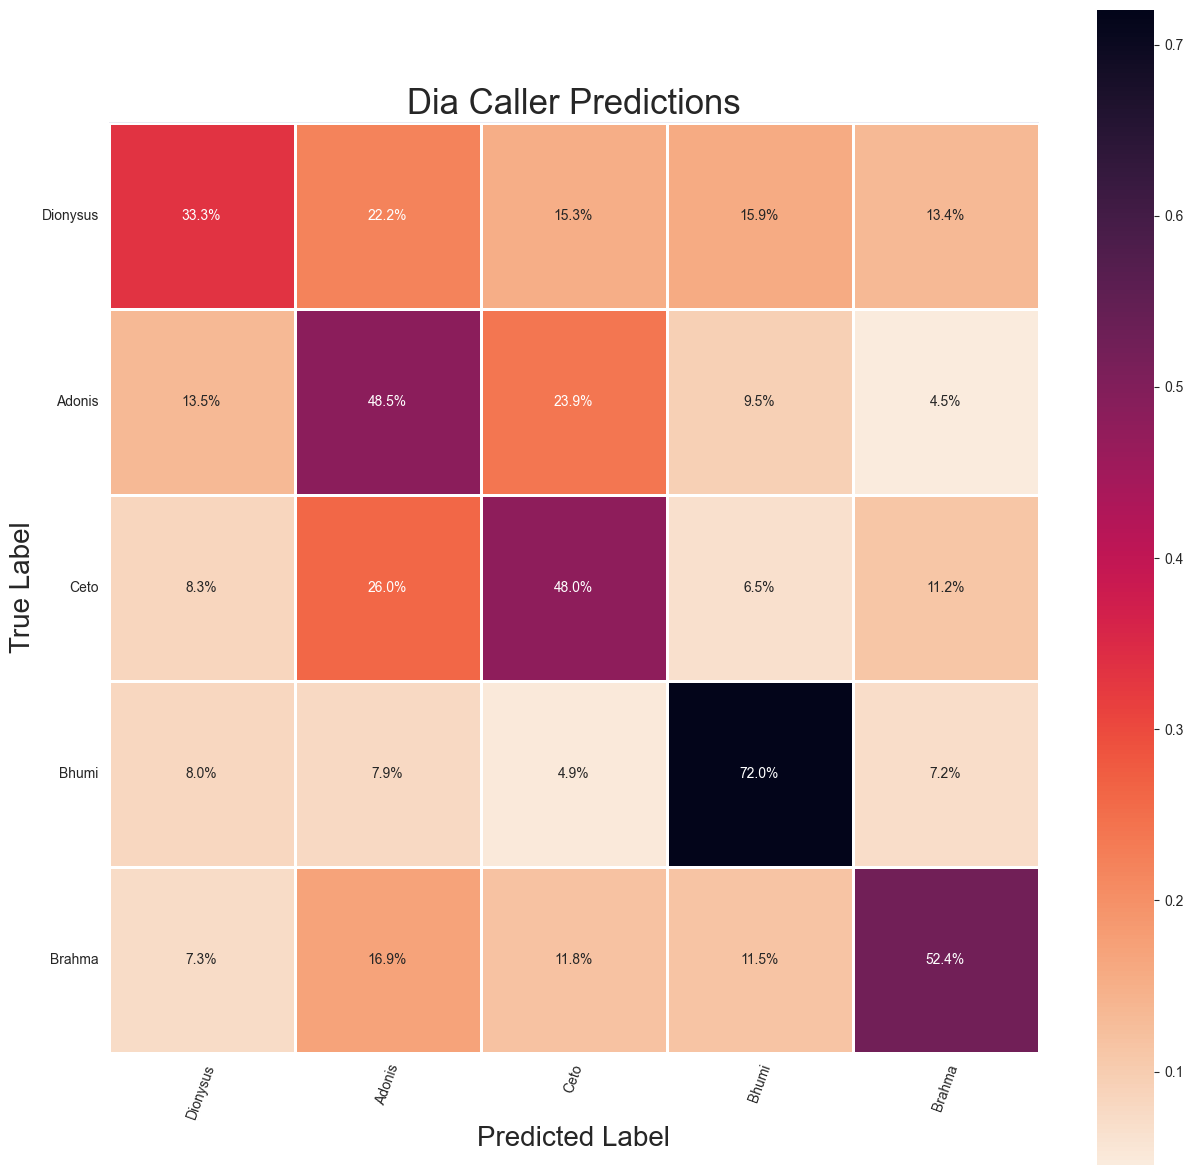

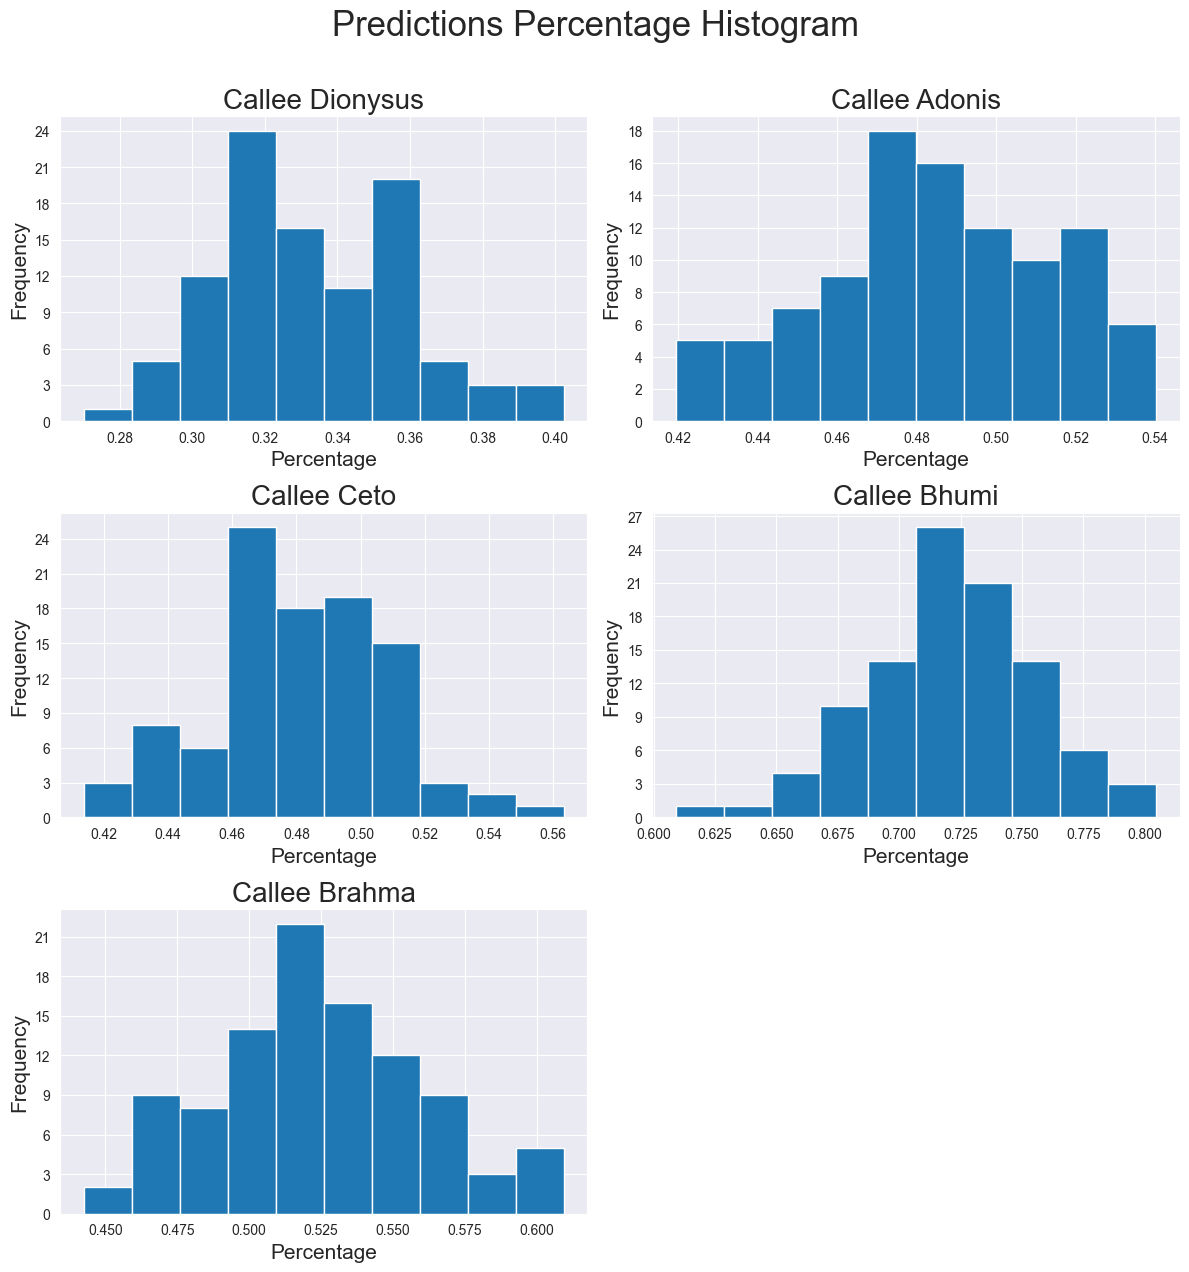

  0%|          | 0/100 [00:00<?, ?it/s]

train: Adonis    285
Bhumi     285
Ceto      285
Dia       285
Ella      285
Name: callee, dtype: int64
test: Adonis    92
Bhumi     92
Ceto      92
Dia       92
Ella      92
Name: callee, dtype: int64


100%|██████████| 100/100 [13:31<00:00,  8.11s/it]


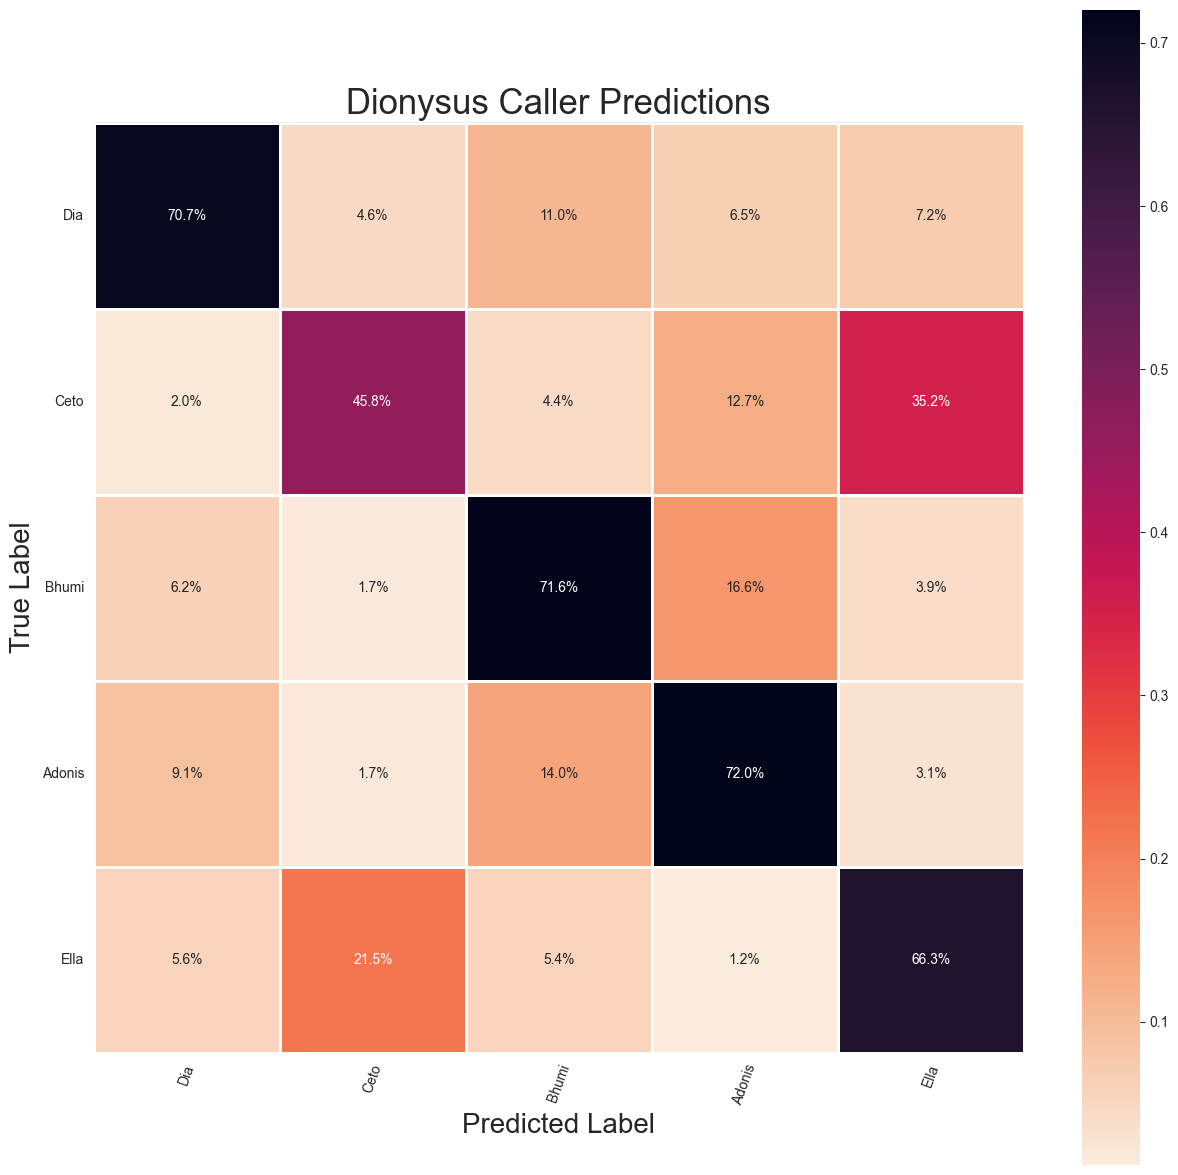

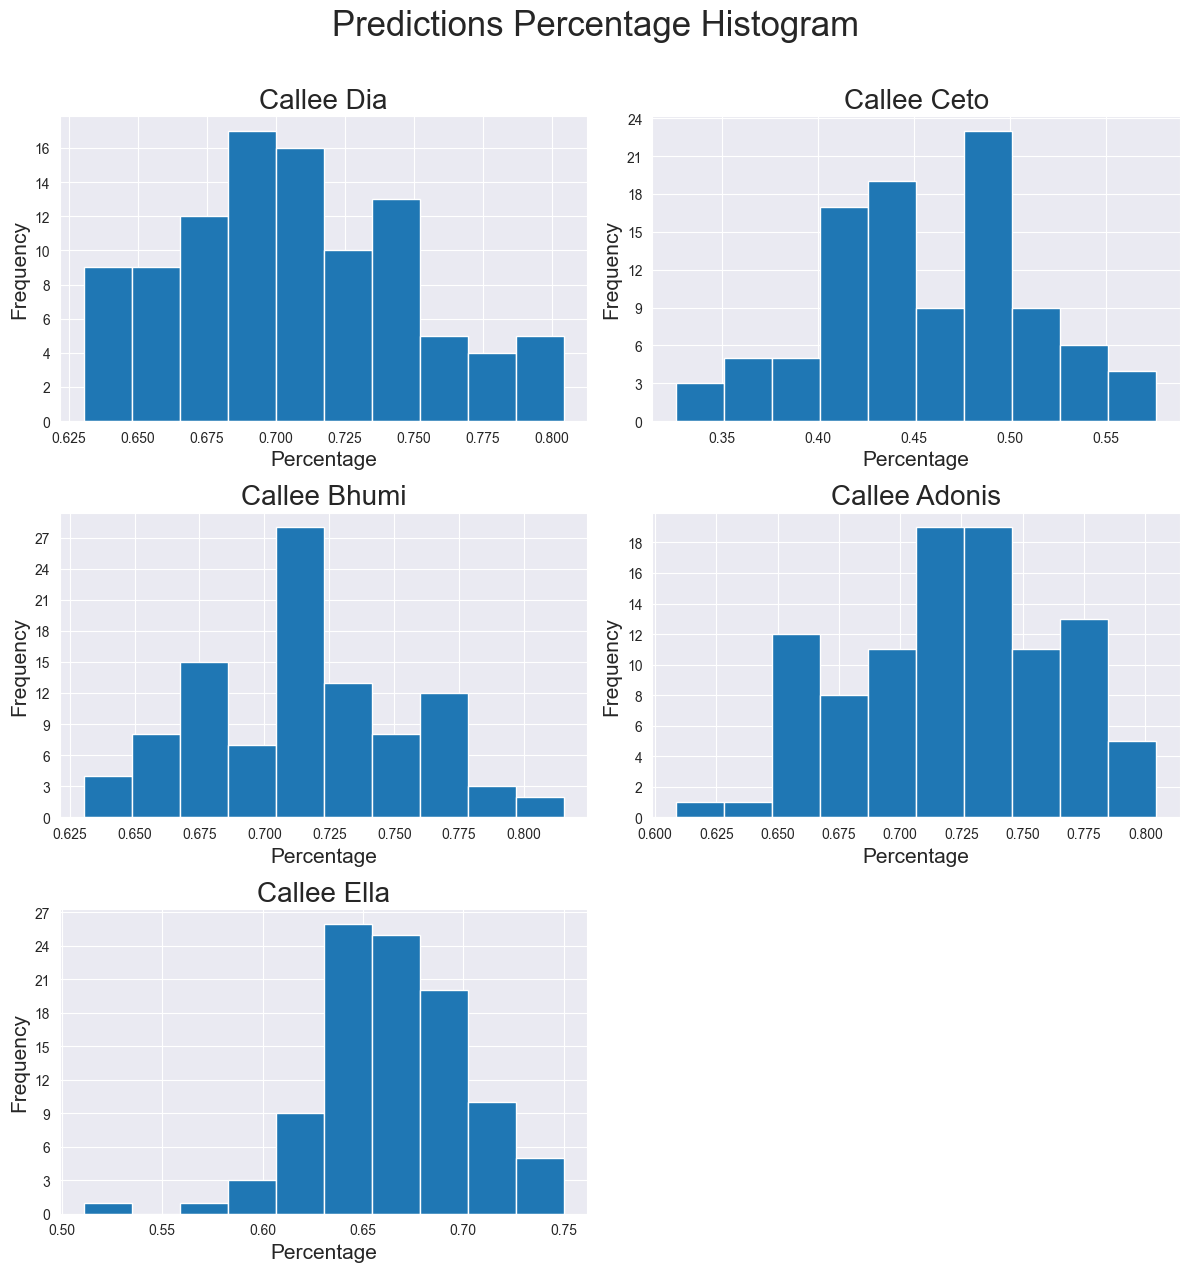

  0%|          | 0/100 [00:00<?, ?it/s]

train: Adonis      111
Bhumi       111
Brahma      111
Chaos       111
Dia         111
Dionysus    111
Name: callee, dtype: int64
test: Adonis      39
Bhumi       39
Brahma      39
Chaos       39
Dia         39
Dionysus    39
Name: callee, dtype: int64


100%|██████████| 100/100 [05:58<00:00,  3.58s/it]


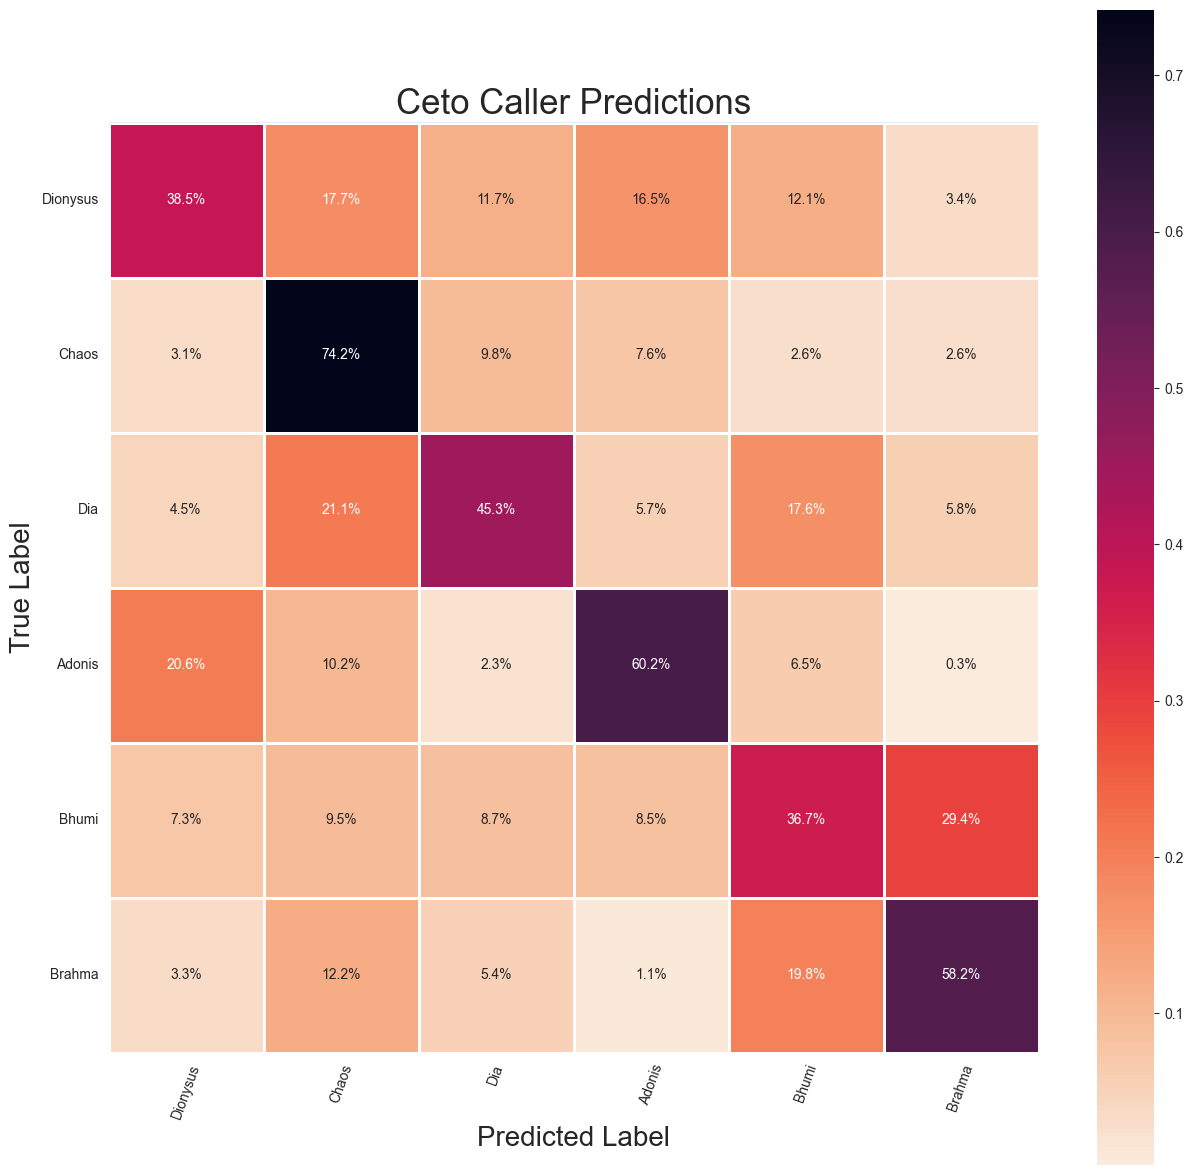

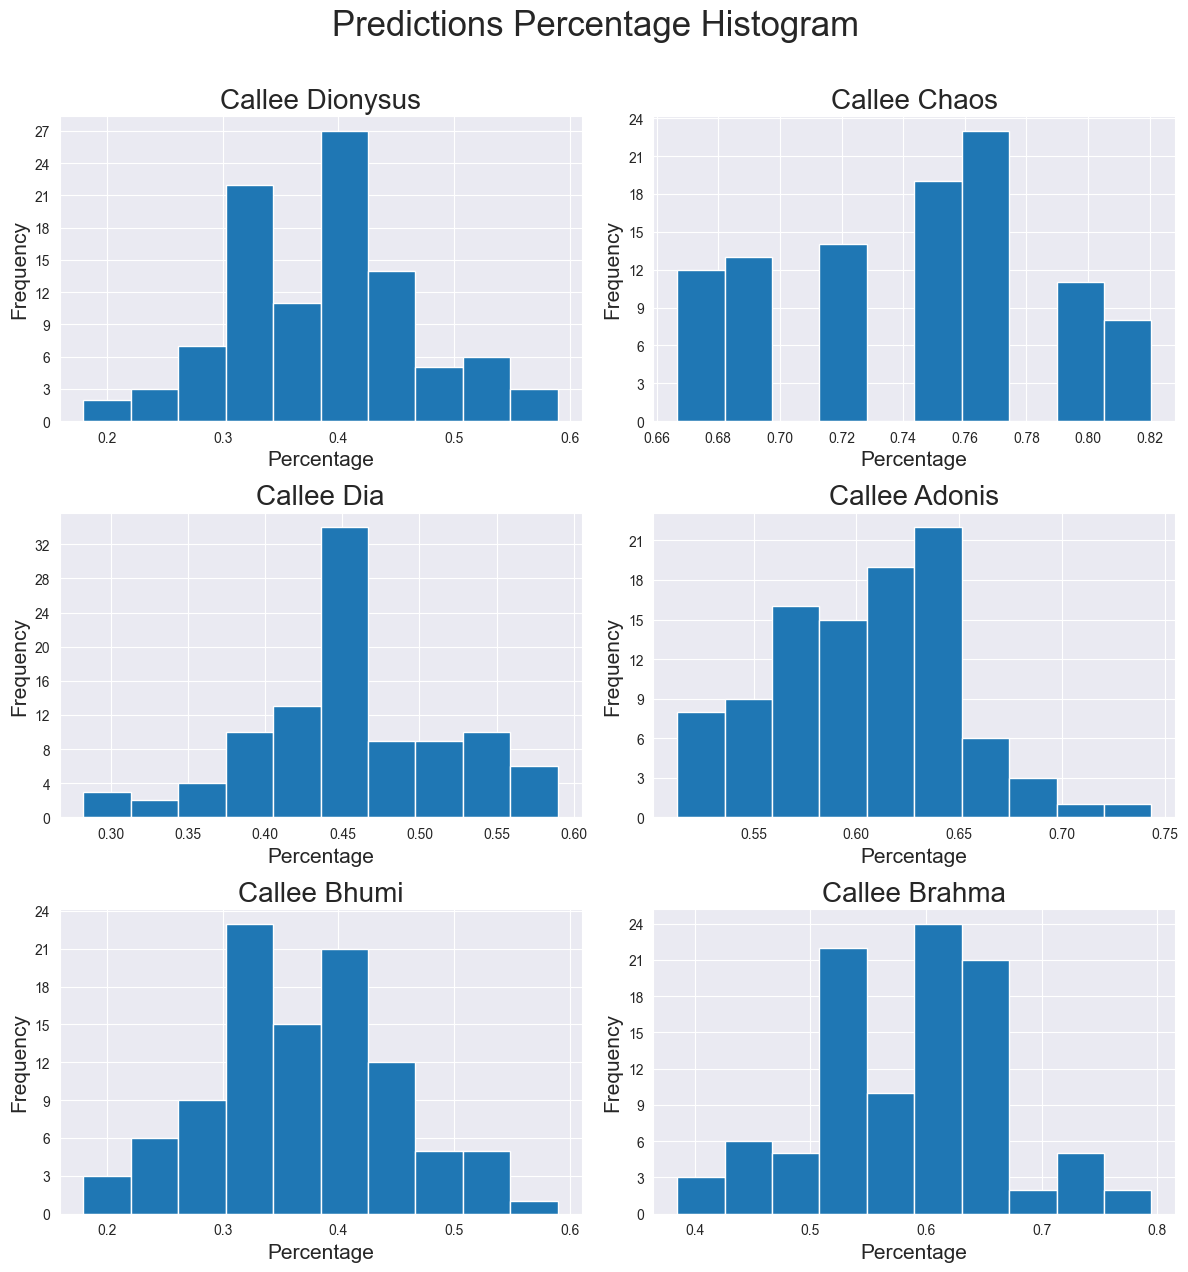

  0%|          | 0/100 [00:00<?, ?it/s]

train: Ceto        98
Dia         98
Dionysus    98
Ella        98
Name: callee, dtype: int64
test: Ceto        31
Dia         31
Dionysus    31
Ella        31
Name: callee, dtype: int64


100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


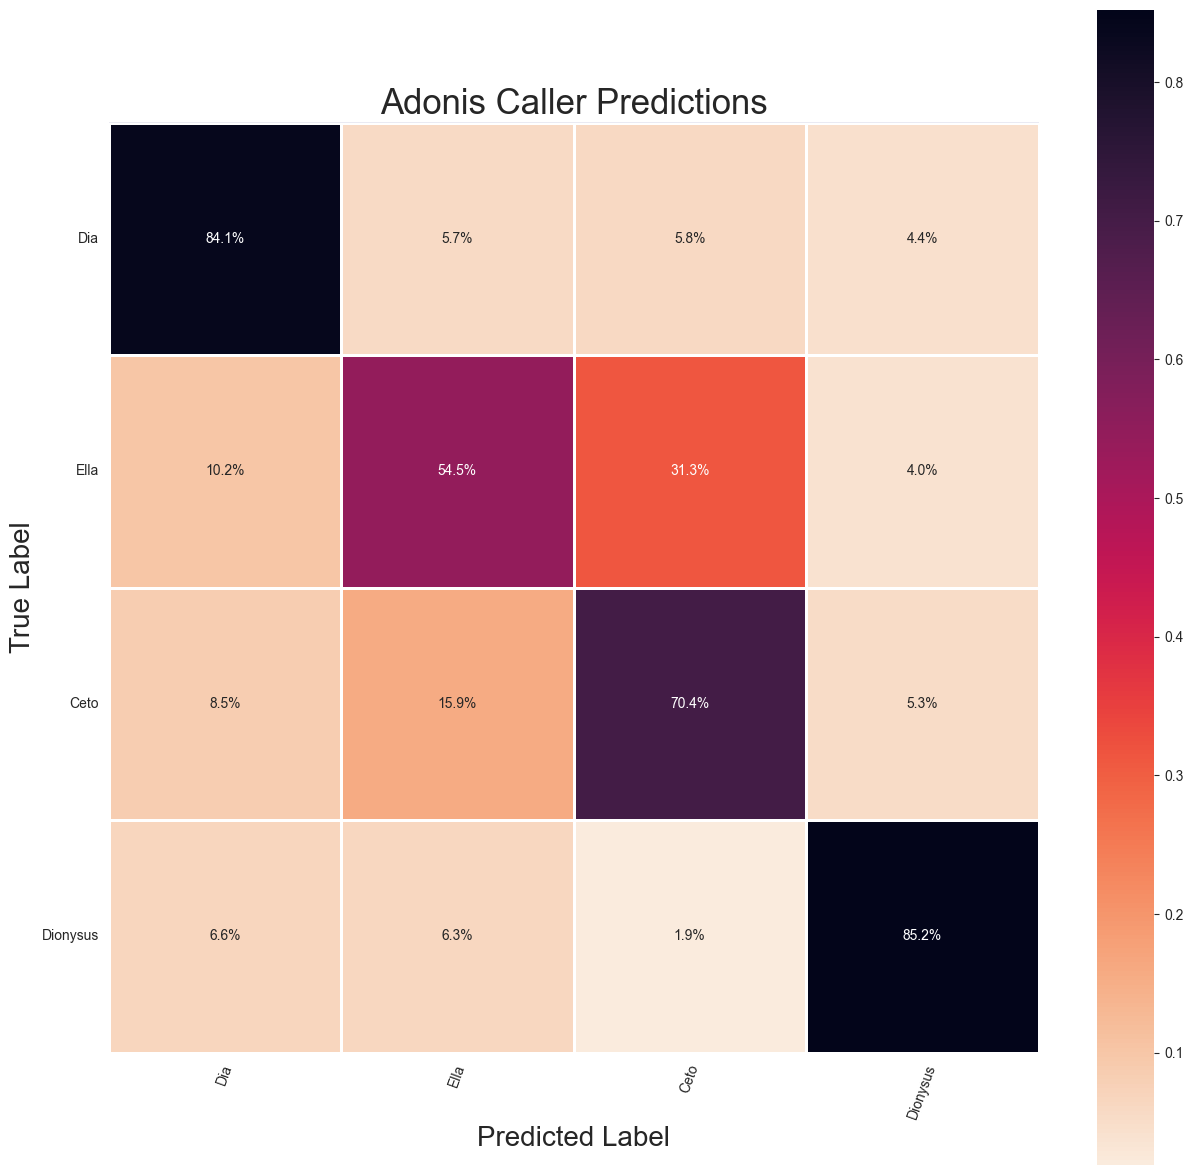

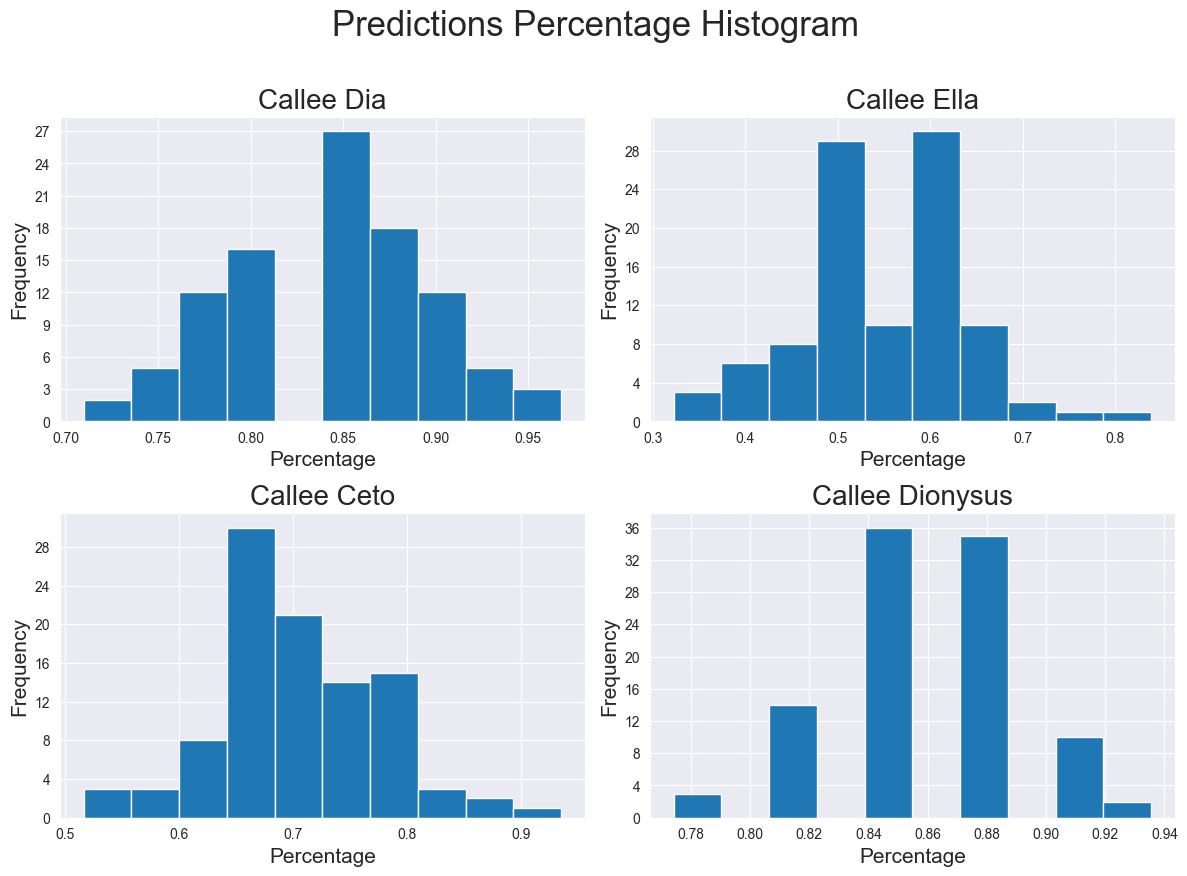

  0%|          | 0/100 [00:00<?, ?it/s]

train: Brahma      71
Dia         71
Dionysus    71
Ella        71
Name: callee, dtype: int64
test: Brahma      25
Dia         25
Dionysus    25
Ella        25
Name: callee, dtype: int64


100%|██████████| 100/100 [02:37<00:00,  1.57s/it]


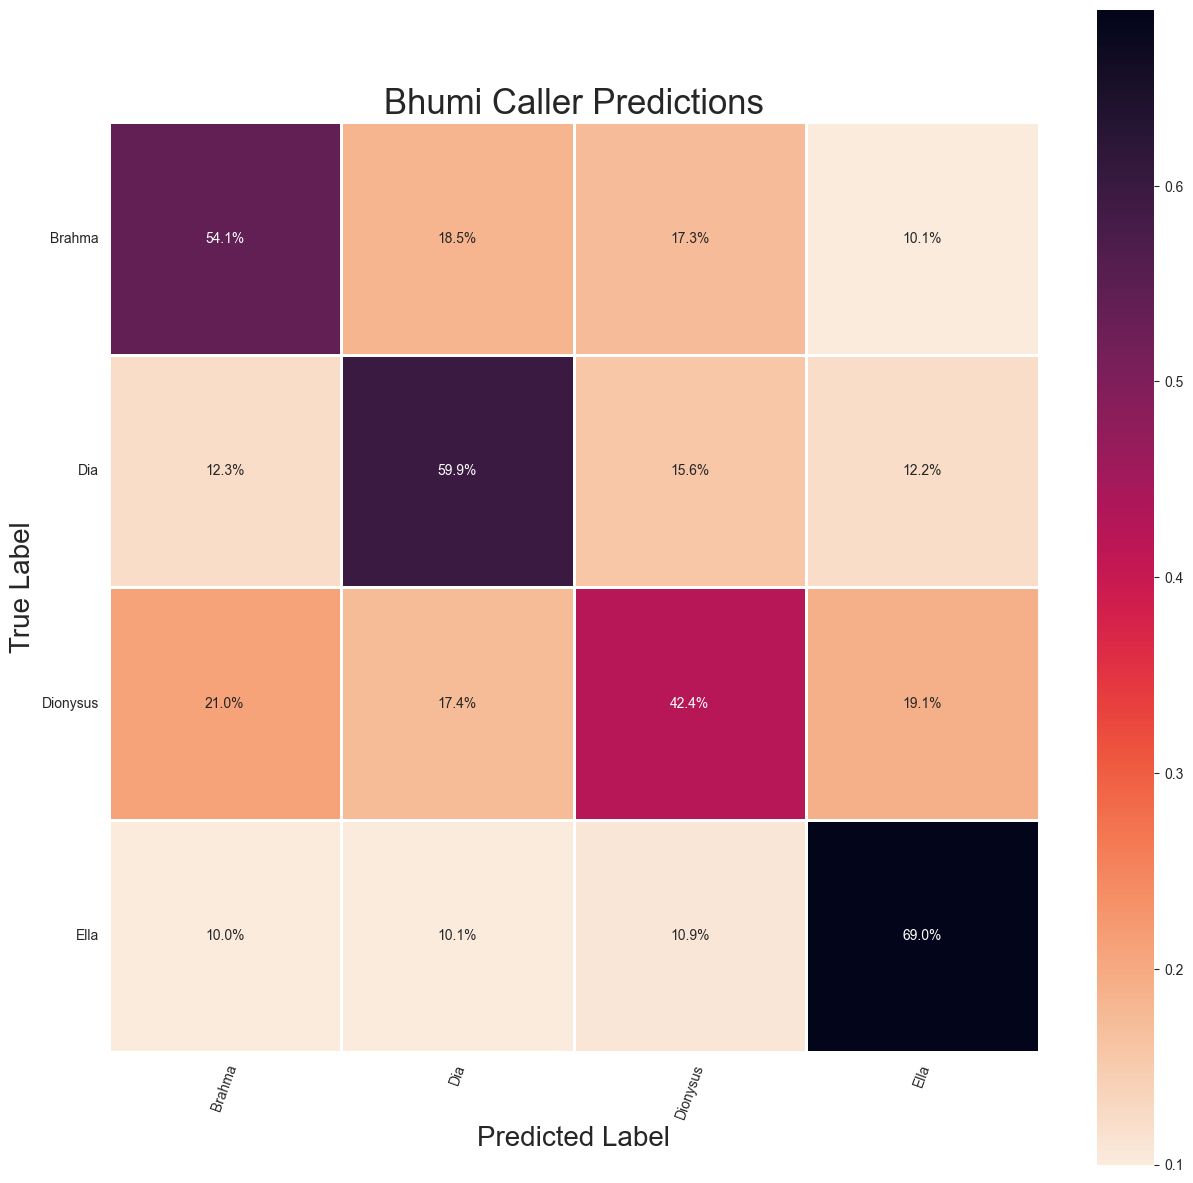

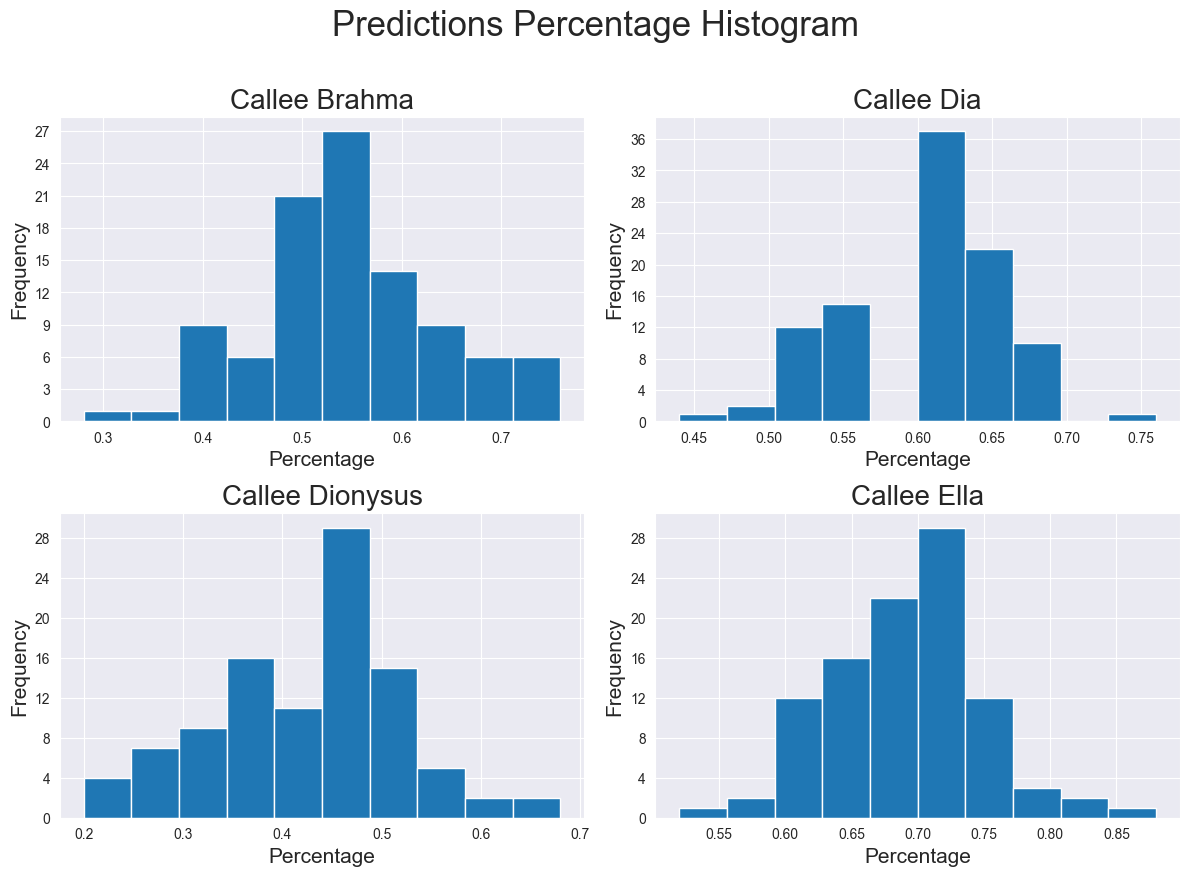

  0%|          | 0/100 [00:00<?, ?it/s]

train: Adonis      104
Bhumi       104
Dia         104
Dionysus    104
Name: callee, dtype: int64
test: Adonis      37
Bhumi       37
Dia         37
Dionysus    37
Name: callee, dtype: int64


100%|██████████| 100/100 [03:13<00:00,  1.94s/it]


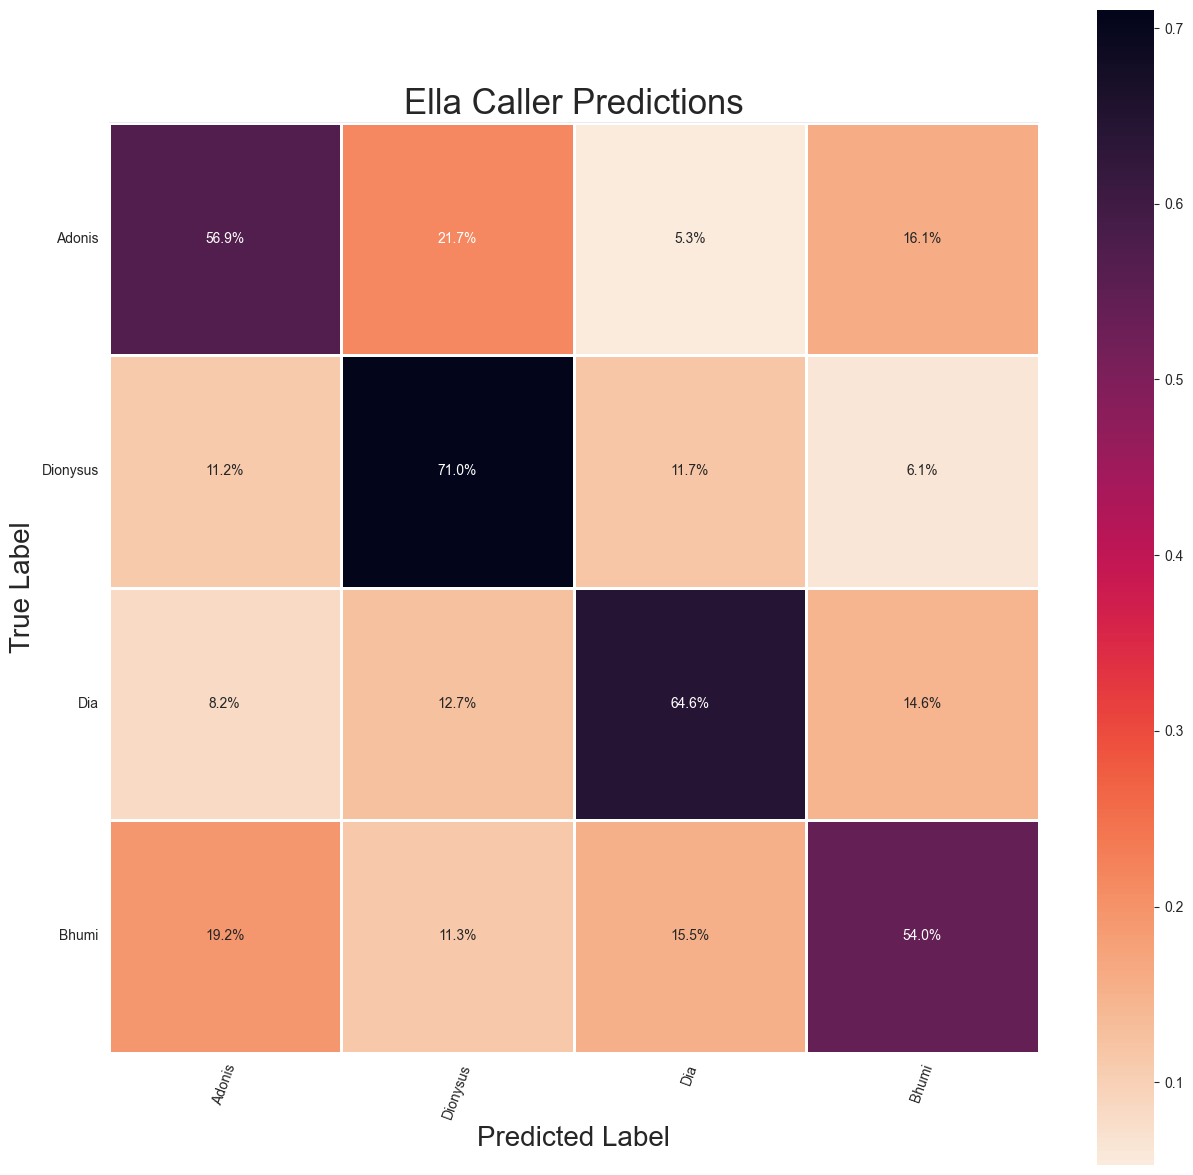

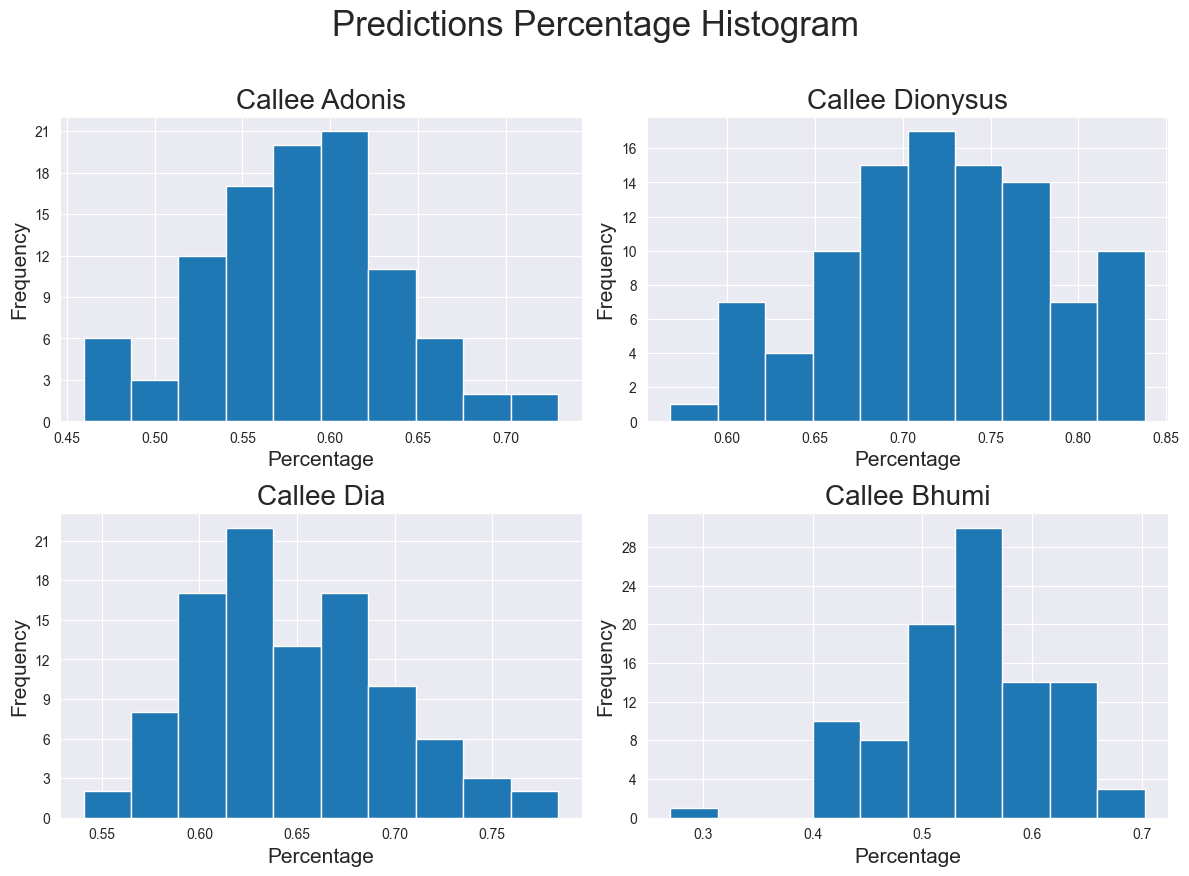

In [9]:
for caller, callees_to_drop, title in [("Dia", ["Ella"], "Dia Caller Predictions"), ("Dionysus", ["Brahma", "Chaos"], "Dionysus Caller Predictions"), ("Ceto", [], "Ceto Caller Predictions"),
                                  ("Adonis", [], "Adonis Caller Predictions"), ("Bhumi", ["Adonis", "Ceto"], "Bhumi Caller Predictions"), ("Ella", [], "Ella Caller Predictions")]:

    cm_list, oob_score, labels = pred_caller_to_callees_train_test(df_flattened, caller, callees_to_drop)
    show_cm(np.mean(cm_list, axis=0), title, labels)
    pred_percent_hist(cm_list, labels)